In [56]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utils as ut
import LIM_class
plt.style.use("../plotting.mplstyle")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
data = xr.open_dataset("./data/ts_Amon_CESM2_piControl_r1i1p1f1.nc")["ts"]
#data = xr.open_dataset("./data/zos_Amon_CESM2_piControl_r1i1p1f1.nc")["zos"]
#data_old = xr.open_dataset("./data/ssta_1950_2021.nc")["ssta"]
mask = xr.open_dataset("./data/sftlf_fx_CESM2_historical_r1i1p1f1.nc")["sftlf"]

#14400 orginial size
data = data[:, :, :]

data = ut.apply_mask(mask, data)
#print("Data : {} + shape {}".format(data, data.shape))

data_anomalies = ut.calculate_monthly_anomalies(data)
#print("Month mean : {} + shape : {}".format(data_anomalies, data_anomalies.shape))

data_cropped =ut.crop_xarray(data_anomalies)
#print("Data cropped : {} + shape : {}".format(data_cropped, data_cropped.shape))


pca_10 = ut.SpatioTemporalPCA(data_cropped, n_components=20)
#pca_10 = ut.SpatioTemporalPCA(data_anomalies, n_components=20)
eof_10 = pca_10.eofs()
pc_10 = pca_10.principal_components()

Data : <xarray.DataArray 'ssta' (time: 864, lat: 13, lon: 35)>
[393120 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
  * lat      (lat) float64 -30.0 -25.0 -20.0 -15.0 -10.0 ... 15.0 20.0 25.0 30.0
  * lon      (lon) float64 -60.0 -55.0 -50.0 -45.0 ... 95.0 100.0 105.0 110.0
    month    (time) int64 ...


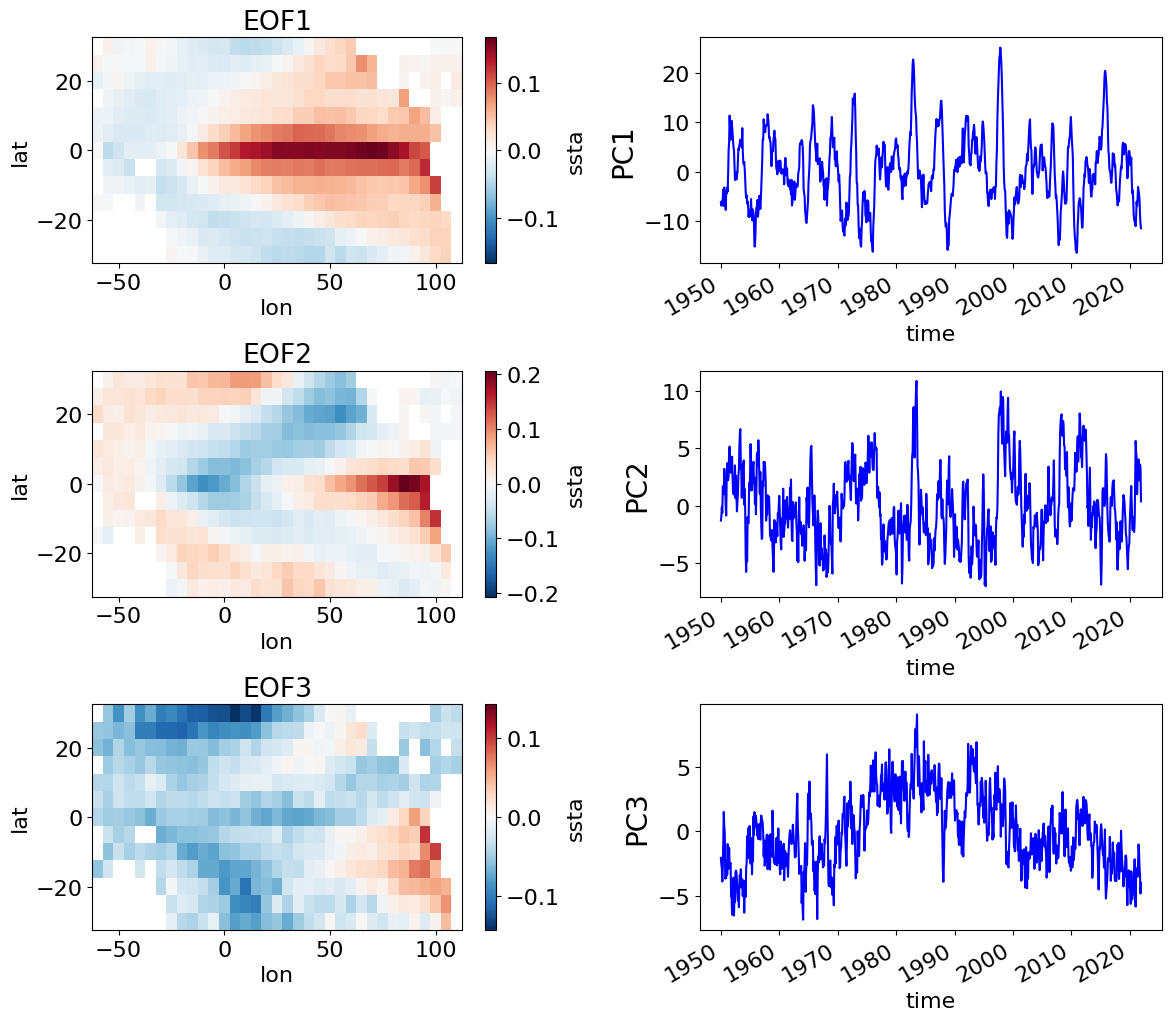

In [58]:
# Set the number of plots to 2
number_of_plots = 3

# Create the figure and axes objects
fig = plt.figure(figsize=(2 * 6, 3.5 * number_of_plots))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    ax = fig.add_subplot(number_of_plots, 2, 2*i+1)
    eof_10[i].plot(ax=ax, cmap="RdBu_r")
    ax.set_title(f"EOF{i+1}")
    ax = fig.add_subplot(number_of_plots, 2, 2*i + 2)
    pc_10.isel(eof=i).plot(ax=ax, color="blue")
    ax.set_ylabel(f"PC{i+1}", fontsize=20)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)
fig.savefig('./plots/svg/EOFS_timeseries_piControl.svg', format='svg')
fig.savefig('./plots/png/EOFS_timeseries_piControl.png', format='png')
plt.show()

In [59]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]
data_test = data[:, index_train:]
# Creating an example LIM object

tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data)

eigenvalues, _, _ = ut.matrix_decomposition(model.green_function)
t_decay = [abs(-(1/np.log(eigenvalue.real))) for eigenvalue in eigenvalues]

print("Eigenvalues : min {} + max {}".format(min(eigenvalues), max(eigenvalues)))
print("T-decay : min {} + max {}".format(min(t_decay), max(t_decay)))
#print("Data train : {} + shape: {}".format(data_train.data, data_train.data.shape))

Eigenvalues : min (0.6523608599022644+0j) + max (0.8978336170660353+0j)
T-decay : min 2.341057395962956 + max 9.278976266729442


In [60]:
# Simulate stochastic differential equation
x_input = data_train.isel(time=0)
times = x_input['time']
x = x_input.data

lim_integration, times_ = model.noise_integration(x, timesteps=499, seed=10, num_comp=len(pc_10))

lim_integration = lim_integration.T
pc_10 = np.array(pc_10)
print("LIMMM : {} + next {} + next {}".format(lim_integration[0][:5], lim_integration[0][50], lim_integration[0][-3:]))
#print("LIMMM : {} + next {} + next {}".format(lim_integration[1][:5], lim_integration[1][50], lim_integration[1][-3:]))
#print("LIMMM : {} + next {} + next {}".format(lim_integration[2][:5], lim_integration[2][50], lim_integration[2][-3:]))
print("PCCC : {} + next {} + next {}".format(pc_10[0][:5], pc_10[0][50], pc_10[0][-3:] ))
#print("PCCC : {} + next {} + next {}".format(pc_10[1][:5], pc_10[1][50], pc_10[1][-3:]))
#print("PCCC : {} + next {} + next {}".format(pc_10[2][:5], pc_10[2][50], pc_10[2][-3:]))


#print("LIM integration : {} + shape {} + type {} ".format(lim_integration, lim_integration.shape, type(lim_integration)))
#print("PC  : {} + shape {} + type {} ".format(pc_10, pc_10.shape, type(pc_10)))

#print("LIM integration : {} + shape {} + type {} ".format(lim_integration_T[:5], lim_integration_T.shape, type(lim_integration_T)))

LIMMM : [-6.29767607 -6.17292376  7.54135221 10.3103286   8.97217398] + next -3.208724142739762 + next [  1.07604396  -8.7342697  -11.53716687]
PCCC : [-6.29767607 -6.92623833 -6.06612333 -6.85552491 -5.17312903] + next -1.5169768421571657 + next [ -8.78229121 -10.73037298 -11.51841333]


In [61]:
# # Set the number of plots to 2
# number_of_plots = 3
# # Create the figure and axes objects
# fig, axs = plt.subplots(number_of_plots, 2, figsize=(20, 65))
#
# # Set titles and plot the contourf and plot for each EOF and PC
# for i in range(number_of_plots):
#     axs[i,1].set_title("PC - integrated {}".format(i + 1), fontsize=30)
#     # Define time variable
#     time = np.arange(len(pc_10[i]))
#     # Convert time to years
#     time_years = time/12 + 1950
#
#     # Plot PC with time on x-axis in years
#     axs[i,0].plot(time_years, pc_10[i][:500])
#     axs[i,0].set_xlabel("Time (years)", fontsize=25)
#
#     # Plot PC with time on x-axis in years for integrated data
#     axs[i,1].plot(time_years, lim_integration[i])
#     axs[i,1].set_xlabel("Time (years)", fontsize=25)
#
#
#
# plt.legend(loc="upper right", fontsize=20)
# # Add padding between subplots and adjust layout
# fig.tight_layout(pad=2)
# #fig.savefig('./plots/svg/EOFS_timeseries_RdBu_r_piControl_.svg', format='svg')
# #fig.savefig('./plots/png/EOFS_timeseries_RdBu_r_piControl_.png', format='png')
# #plt.show()

In [62]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]

eps = 0.01

# original fit
tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data, eps=eps)

logar_matr = model.logarithmic_matrix
noise_matr = model.noise_covariance


# Get input data
x_input = data_test.isel(time=0)
x_input = x_input.data

# Forecast mean using LIM model
lim_integration, times_ = model.noise_integration(x_input, timesteps=10000, num_comp=len(pc_10))
lim_integration = lim_integration.T

tau = 1
model2 = LIM_class.LIM(tau)
model2.fit(lim_integration, eps=eps)

logar_matr2 = model2.logarithmic_matrix
noise_matr2 = model2.noise_covariance

G_min : [-0.19563602961045468, -0.9474729811959202]
G_max : [0.9575584502374929, 1.1826778571661245]
L_min : [-0.398029203438352, -3.7589280088659676]
L_max : [0.31233623741236255, 2.107148027236266]
Q_min : [-0.4820703189184887, -6.523970166911855]
Q_max : [3.3248371794687746, 20.429276195286796]


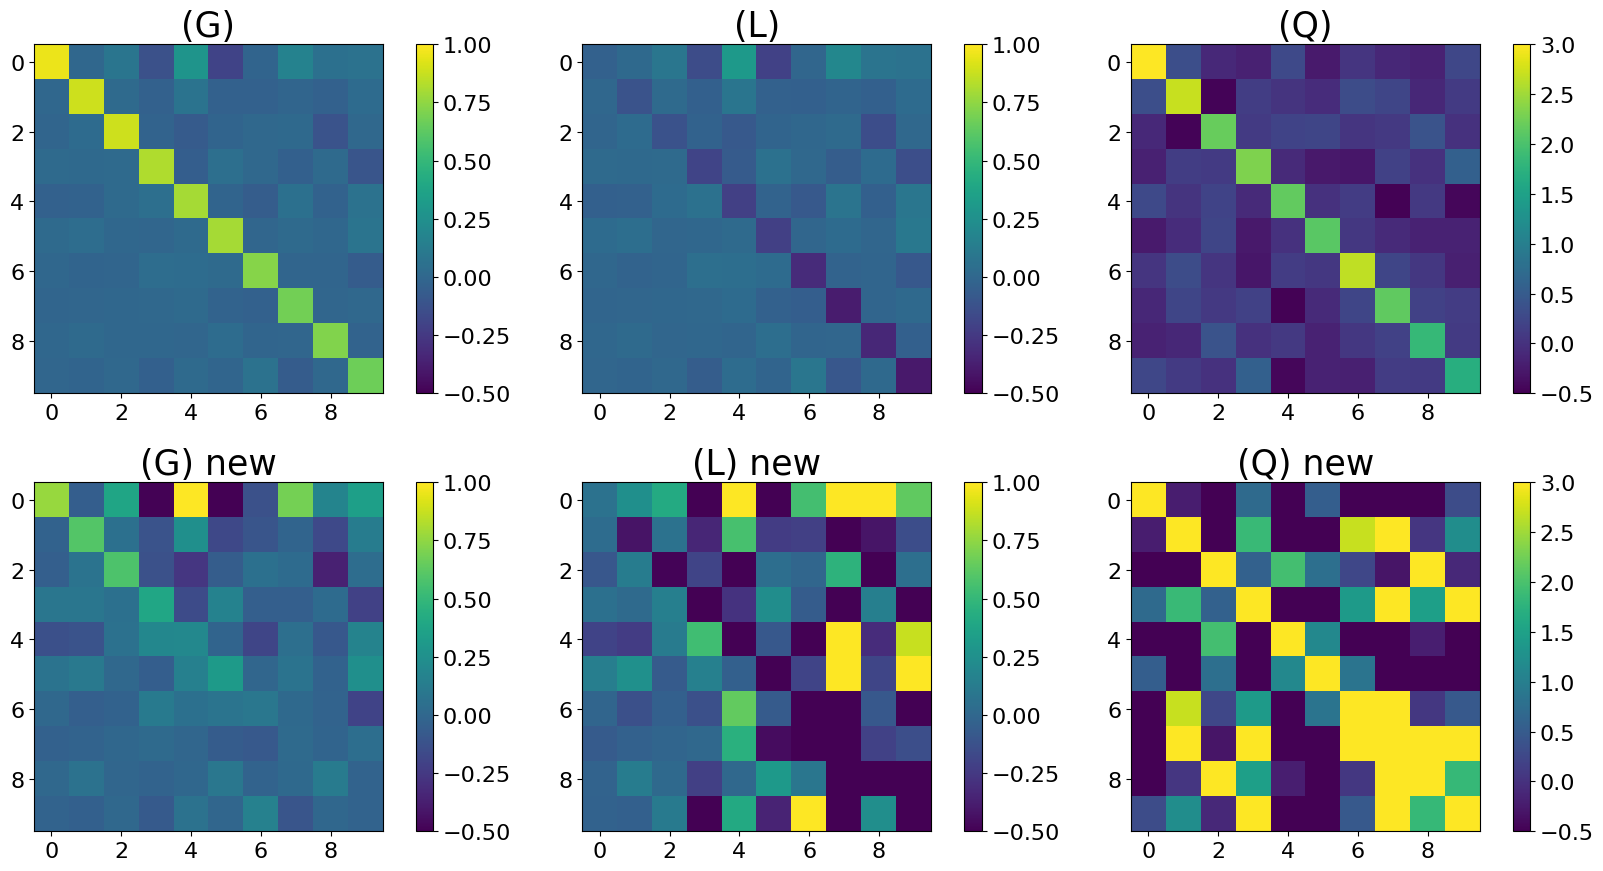

In [63]:
# Plot G, L, Q
fig, axs = plt.subplots(2, 3, figsize=(18, 9))

# Plot G
im1 = axs[0][0].imshow(model.green_function, vmin=-0.5, vmax=1)
#im1 = axs[0][0].imshow(model.green_function)
axs[0][0].set_title('(G)', fontsize=25)
fig.colorbar(im1, ax=axs[0][0])
im11 = axs[1][0].imshow(model2.green_function, vmin=-0.5, vmax=1)
#im11 = axs[1][0].imshow(model2.green_function)
axs[1][0].set_title('(G) new', fontsize=25)
fig.colorbar(im11, ax=axs[1][0])

g_min = [np.min(model.green_function), np.min(model2.green_function)]
g_max = [np.max(model.green_function), np.max(model2.green_function)]
print("G_min : {}".format(g_min))
print("G_max : {}".format(g_max))

# Plot L
im2 = axs[0][1].imshow(np.real(model.logarithmic_matrix), vmin=-0.5, vmax=1)
#im2 = axs[0][1].imshow(np.real(model.logarithmic_matrix))
axs[0][1].set_title('(L)', fontsize=25)
fig.colorbar(im2, ax=axs[0][1])
im21 = axs[1][1].imshow(np.real(model2.logarithmic_matrix), vmin=-0.5, vmax=1)
#im21 = axs[1][1].imshow(np.real(model2.logarithmic_matrix))
axs[1][1].set_title('(L) new', fontsize=25)
fig.colorbar(im21, ax=axs[1][1])

l_min = [np.min(np.real(model.logarithmic_matrix)), np.min(np.real(model2.logarithmic_matrix))]
l_max = [np.max(np.real(model.logarithmic_matrix)), np.max(np.real(model2.logarithmic_matrix))]
print("L_min : {}".format(l_min))
print("L_max : {}".format(l_max))


# Plot Q
im3 = axs[0][2].imshow(np.real(model.noise_covariance), vmin=-0.5, vmax=3)
#im3 = axs[0][2].imshow(np.real(model.noise_covariance))
axs[0][2].set_title('(Q)', fontsize=25)
fig.colorbar(im3, ax=axs[0][2])
im31 = axs[1][2].imshow(np.real(model2.noise_covariance), vmin=-0.5, vmax=3)
#im31 = axs[1][2].imshow(np.real(model2.noise_covariance))
axs[1][2].set_title('(Q) new', fontsize=25)
fig.colorbar(im31, ax=axs[1][2])

q_min = [np.min(np.real(model.noise_covariance)), np.min(np.real(model2.noise_covariance))]
q_max = [np.max(np.real(model.noise_covariance)), np.max(np.real(model2.noise_covariance))]
print("Q_min : {}".format(q_min))
print("Q_max : {}".format(q_max))

plt.tight_layout()
fig.savefig('./plots/svg/G_Q_L_function_piControl.svg', format='svg')
fig.savefig('./plots/png/G_Q_L_function_piControl.png', format='png')
plt.show()

C:\Users\felix\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


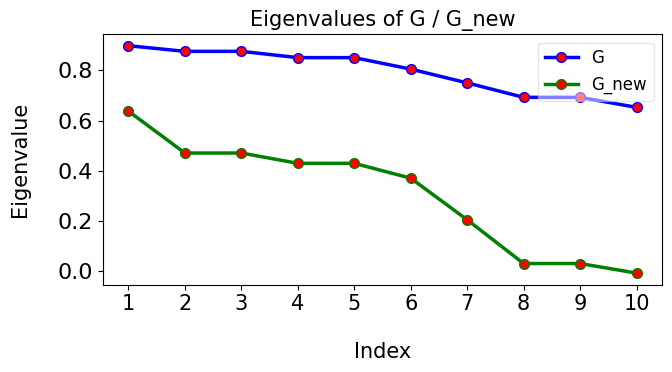

In [64]:
# Plotting eigenvalues of G
eigenvalues, _, w = ut.matrix_decomposition(model.green_function)
eigenvalues2, _, w = ut.matrix_decomposition(model2.green_function)

x = np.arange(1, len(eigenvalues) + 1)

# Plot the eigenvalues
plt.plot(x, eigenvalues, marker='o', linestyle='-', color='b', markersize=7, markerfacecolor='r', linewidth=2.5,
         label='G')
plt.plot(x, eigenvalues2, marker='o', linestyle='-', color='g', markersize=7, markerfacecolor='r', linewidth=2.5,
         label='G_new')
# Set the labels and title
plt.xlabel('Index', fontsize=15, labelpad=20)
plt.ylabel('Eigenvalue', fontsize=15, labelpad=20)
plt.title('Eigenvalues of G / G_new', fontsize=15)

# Set the x-axis tick labels
plt.xticks(x, fontsize=15)
plt.legend(loc="upper right", fontsize=12)

# Display the plot
plt.savefig('./plots/svg/eigenvalues_G_combined_piControl.svg', format='svg')
plt.savefig('./plots/png/eigenvalues_G_combined_piControl.png', format='png')
plt.show()